# Time line plot

# load related library

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np


import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame


from ipywidgets import widgets 
from ipywidgets import *  
from IPython.display import display,clear_output
#https://github.com/jupyter-widgets/ipywidgets/issues/134 about ouput
#http://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/ about plot+ipywidgets
#https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
from ipywidgets import Layout
import folium
from datetime import datetime
from datetime import date
from dateutil import rrule

from traitlets import directional_link

# install rtree
# https://github.com/kjordahl/SciPy-Tutorial-2015/issues/1
# http://jspeis.com/installing-rtree-on-mac-os-x/

plt.style.use('ggplot')

def loadJson(filename):
	import json
	f = open(filename, "r", encoding = "utf-8")
	output = json.load(f)
	f.close()
	return output

# load score information

In [2]:
# load score information
column_name_score=['title', 'score']

scores = {}
scores["OL"] = {}
scores["MPQA"] = {}
scores["LIWC"] = {}
    
scores["OL"]["positive"] = pd.read_csv("score_file/pos_score_OL_.csv", names=column_name_score)
scores["OL"]["negative"] = pd.read_csv("score_file/neg_score_OL_.csv", names=column_name_score)
scores["OL"]["positive+negative"] = pd.read_csv("score_file/pos_neg_score_OL_.csv", names=column_name_score)
scores["MPQA"]["positive"] = pd.read_csv("score_file/pos_score_MPQA_.csv", names=column_name_score)
scores["MPQA"]["negative"] = pd.read_csv("score_file/neg_score_MPQA_.csv", names=column_name_score)
scores["MPQA"]["positive+negative"] = pd.read_csv("score_file/pos_neg_score_MPQA_.csv", names=column_name_score)
scores["LIWC"]["positive"] = pd.read_csv("score_file/pos_score_LIWC_.csv", names=column_name_score)
scores["LIWC"]["negative"] = pd.read_csv("score_file/neg_score_LIWC_.csv", names=column_name_score)
scores["LIWC"]["positive+negative"] = pd.read_csv("score_file/pos_neg_score_LIWC_.csv", names=column_name_score)

In [3]:
print (scores["OL"]["positive"].head())

                title  score
0  Stripe-backed_wren     34
1             Rototom     25
2          Eremobates     59
3  Richard_Whitbourne     20
4                 ESS    250


# load date information

In [4]:
dates = {}
column_name_date = ['title','date']
dates["People"] = pd.read_csv("person_birthdate.csv",names=column_name_date)
dates["Events"] = pd.read_csv("event_date.csv",names=column_name_date)

In [5]:
print (dates["People"].head())

             title        date
0    Ricardo_Prado  1965-01-03
1  Gottlieb_Göller  1935-05-31
2     Henry_Wiggin  1824-02-14
3   Fredrik_Lundin  1963-04-07
4  Gustaf_Svensson  1882-03-17


# functions for preprocessing

In [6]:
doc_length_df = pd.read_csv("docs_length.csv",names=['title','length'])
doc_length_okay = set(doc_length_df[doc_length_df['length'] < 10]['title'])
print ("There are %d out of %d articles whose token length smaller than 10."%(len(doc_length_okay),len(doc_length_df)))


There are 733537 out of 5416537 articles whose token length smaller than 10.


In [7]:

def merge_date_score(lexicon_name,sentiment,category):
    # merge date and score to "title, date, score" 
    # with certain lexicon (OL, MPQA, LIWC),
    #              sentiment (positive, negative, positive+negative)
    #              category (People, Events)
    title_date_score = dates[category].merge(scores[lexicon_name][sentiment],how='inner')
    print ("before exclude short articles")
    print (title_date_score.shape)
    title_date_score = title_date_score[~title_date_score['title'].isin(doc_length_okay)]
    print ("after exclude short articles")
    print (title_date_score.shape)
    print ("rows of dates[category], rows of scores[lexicon_name][sentiment]:")
    print (dates[category].shape,scores[lexicon_name][sentiment].shape)
    return title_date_score
#dateSenti_withBC = merge_date_score("OL","positive","People")

In [8]:
# here we exclude all entities with a date BC ,before 0000 , and score=1000
def exclude_BC(df):
    bc_list = [one for one in df['date'] if one.startswith("-")]
    df_withoutBC = df[~df['date'].isin(bc_list)]
    print ("There are %d dates before Christ,%d entities left after excluding"%(len(bc_list),len(df_withoutBC)))
    return df_withoutBC
# # for positive OL People, 10 of 3888
# # we got 3878 entities
# test = [one for one in dateSenti['date'] if one.startswith("-")]
# print (test)
# dateSenti_withoutBC = dateSenti[~dateSenti['date'].isin(test)]
# print (len(dateSenti_withoutBC))
# #print (len([one for one in dateSenti['date'] if one.startswith("-")]))
def exclude_high_score(df):
    df = df[df['score']!=1000]
    return df
# dateSenti = exclude_BC(dateSenti_withBC)
# dateSenti = exclude_high_score(dateSenti)
# print (dateSenti.head())


In [9]:
# here we get month(str) column
def add_month_column(df):
    new_list = [one[:7] for one in df['date']]
    df = df.assign(month=pd.Series(new_list).values)
    return df
# monthSenti = add_month_column(dateSenti)
# print (monthSenti.head())


In [10]:
def add_year_column(df):
    new_list = [one[:4] for one in df['date']]
    df = df.assign(year=pd.Series(new_list).values)
    return df

In [11]:
# here we get median score for each month
# time_column_name:tcn, score_column_name:scn
def score_median_group_by_column(df,tcn,scn):
    out_df = df.groupby(tcn).agg({scn:np.median}).reset_index()
    return out_df
# df_month_score=score_median_group_by_column(monthSenti,'month','score')
# print (df_month_score.head())

In [12]:
# test_df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100],[1,2],[2,13]]),columns=['a', 'b'])
# test_df

In [13]:
# df1 = test_df.groupby('a').quantile(0.25)
# print (df1)

In [14]:
def score_percentile_group_by_column(df,tcn,scn,percentile):
    out_df = df.groupby(tcn).quantile(percentile).reset_index()
    return out_df
# df_month_score=score_percentile_group_by_column(monthSenti,'month','score',0.25)
# print (df_month_score.head())

In [15]:
def add_datetimeMonth_column(df):
    # df.loc[] is more efficient than df[], and prevent SettingWithCopyWarning
    #dateSenti.loc[:,'datetimetype']=pd.Series(new_list,index=dateSenti.index)
    # more efficient: assign
    new_list = [datetime.strptime(one,'%Y-%m') for one in df['month']]
    print (new_list[1])
    df = df.assign(datetime_month=pd.Series(new_list).values)
    return df
# df_datetimeMonth_score = add_datetimeMonth_column(df_month_score)
# print (df_datetimeMonth_score.head())

In [16]:
def add_datetimeYear_column(df):
    new_list = [datetime.strptime(one,'%Y') for one in df['year']]
    df = df.assign(datetime_year=pd.Series(new_list).values)
    return df

# Now you can jump to Time Plot Section

Now you can jump to time plot section.
The comments below doesn't need to run (which are included in funtion get_displayed_df and function time_plot)
If you want to run it step by step, then you can use them.

In [27]:
# here we set start date and end date for timeline
start_yy = 1000
start_mm = 1
start_dd = 1

start_date = date(start_yy,start_mm,start_dd)
end_date = date.today()
print ("start date of x-axis: %s"%(start_date))
print ("end date x-axis: %s"%(end_date))



start date of x-axis: 1000-01-01
end date x-axis: 2017-10-11


In [31]:
# here we prepare data for x-axis
xaxis_value = [day for day in rrule.rrule(rrule.MONTHLY,dtstart=start_date,until=end_date)]
print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))

value for x-axis looks like this: 
2017-10-01 00:00:00 
len(x-axis): 12214


In [33]:
# here we extract items will be displayed in timeline (date within x-axis range)
df_display = df_datetimeMonth_score[df_datetimeMonth_score['datetime_month'].isin(xaxis_value)]
print (df_display.head())

      month  score       datetime_month
24  1001-03     28  1001-03-01 00:00:00
25  1014-05     46  1014-05-01 00:00:00
26  1030-07     50  1030-07-01 00:00:00
27  1040-02     37  1040-02-01 00:00:00
28  1049-04     24  1049-04-01 00:00:00


<class 'datetime.date'> <class 'datetime.date'>


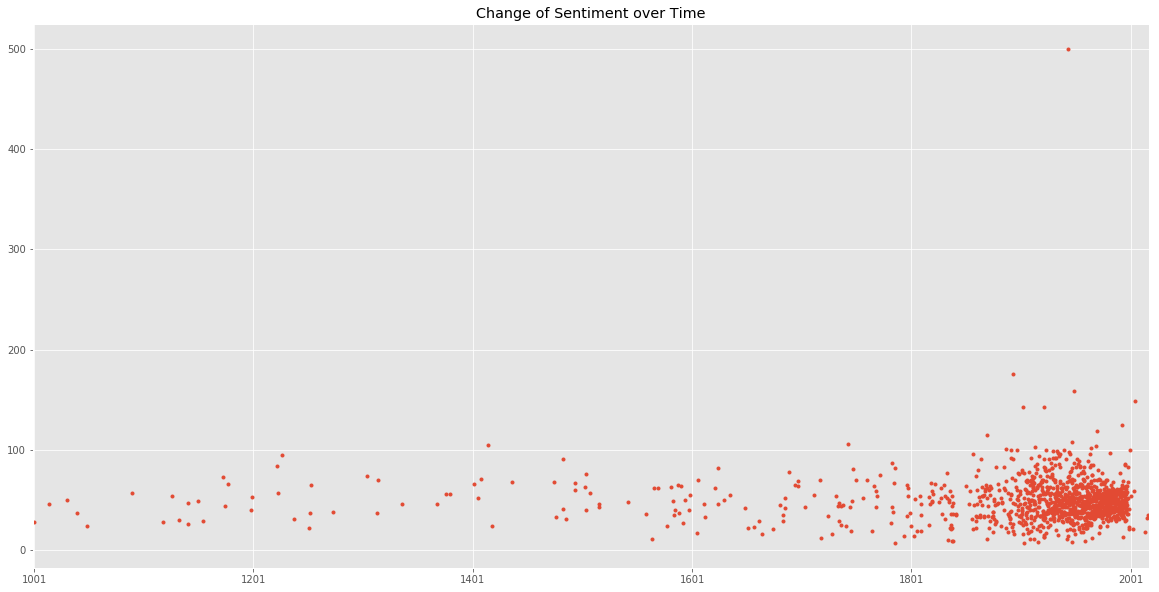

In [41]:
# here we create the plot
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Change of Sentiment over Time')


# xstart = pd.to_datetime(start_date)
# xend = pd.to_datetime(end_date)
print (type(start_date),type(xstart))
#ax.set_xlim([xstart,xend])
ax.set_xlim([start_date,end_date])
ax.plot(df_display.datetime_month,df_display.score,'.')


# Time plot section

# Time plot for median (month, year)

# Time plot for month

In [17]:
def get_displayed_df_for_month(lexicon_name,sentiment,category,xaxis_value):
    # load score, date information before running this function
    # get scores dictionary, dates dictionary
    # dates
    # scores
    
    # preprocessing
    # merge date and score
    dateSenti_withBC = merge_date_score(lexicon_name,sentiment,category)
    # exclude date BC
    dateSenti = exclude_BC(dateSenti_withBC)
    # exclude high score (score == 1000)
    dateSenti = exclude_high_score(dateSenti)
    # add month(str) column
    monthSenti = add_month_column(dateSenti)
    # get score_median for each month
    df_month_score=score_median_group_by_column(monthSenti,'month','score')
    # create a new column to store datetime type of month 
    df_datetimeMonth_score = add_datetimeMonth_column(df_month_score)

    # extract items will be displayed in timeline (date within x-axis range)
    df_display = df_datetimeMonth_score[df_datetimeMonth_score['datetime_month'].isin(xaxis_value)]
    #print (df_display.head())  
    return df_display
    

In [18]:
def time_plot_for_month(lexicon_names,sentiments,categories,timeRange_start):
    # load score, date information
    # get scores dictionary, dates dictionary
    # dates
    # scores
    # import functions
    
    # here we set start date and end date for timeline
    # timeRange_end is today
    # timeRange_start is a list [1000,1,1] consist of 3 int for year, month, date
    start_yy,start_mm,start_dd = timeRange_start

    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    print ("start date of x-axis: %s"%(start_date))
    print ("end date x-axis: %s"%(end_date))
    
    # prepare data for x-axis
    # prepare data for x-axis
    xaxis_value = [day for day in rrule.rrule(rrule.MONTHLY,dtstart=start_date,until=end_date)]
    print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Changes of Sentiment over Time')
    ax.set_xlim([start_date,end_date])
    
    # get dataframe for month and score
    #index = 0
    #df_list = []
    for category in categories:
        for sentiment in sentiments:
            for lexicon in lexicon_names:
                df_temp = get_displayed_df_for_month(lexicon,sentiment,category,xaxis_value)
                temp_label = sentiment+" score distribution for "+category+" based on "+lexicon
                ax.plot(df_temp.datetime_month,df_temp.score,label=temp_label)
                #df_list.append(df_temp)
                #index += 1
    
    #legend = ax.legend(loc='upper center',fontsize='x-large')
    #legend.get_frame().set_facecolor('#00FFCC')
    ax.legend(loc='upper right',fontsize='x-large')
    plt.show()
#     for df in df_list:
#         temp_label = sentiment+" score distribution for "+category+" based on "+lexicon
#         ax.plot(df.datetime_month,df.score,'.',label=sentiment+" score distribution for "+)

start date of x-axis: 1900-01-01
end date x-axis: 2017-10-11
value for x-axis looks like this: 
2017-10-01 00:00:00 
len(x-axis): 1414
There are 10 dates before Christ,3878 entities left after excluding
0015-09-01 00:00:00
There are 10 dates before Christ,3878 entities left after excluding
0015-09-01 00:00:00
There are 10 dates before Christ,3878 entities left after excluding
0015-09-01 00:00:00
There are 10 dates before Christ,3878 entities left after excluding
0015-09-01 00:00:00


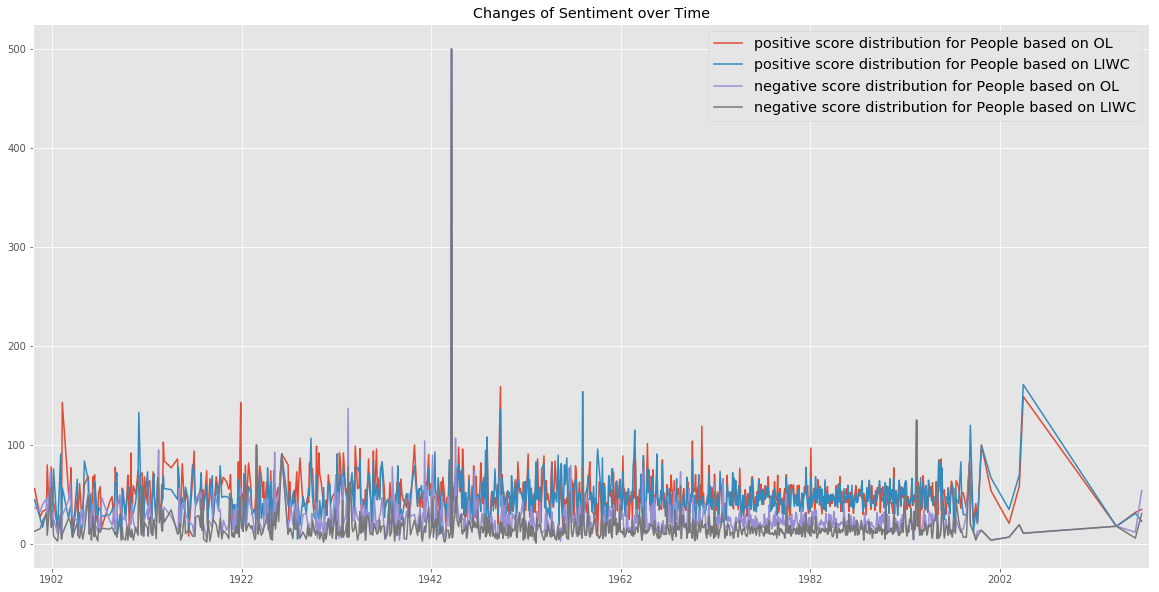

In [75]:
time_plot_for_month(["OL","LIWC"],["positive","negative"],["People"],[1900,1,1])

# Time plot based on year

In [19]:
def get_displayed_df_for_year(lexicon_name,sentiment,category,xaxis_value):
    # load score, date information before running this function
    # get scores dictionary, dates dictionary
    # dates
    # scores
    
    # preprocessing
    # merge date and score
    dateSenti_withBC = merge_date_score(lexicon_name,sentiment,category)
    # exclude date BC
    dateSenti = exclude_BC(dateSenti_withBC)
    # exclude high score (score == 1000)
    dateSenti = exclude_high_score(dateSenti)
    # add year(str) column
    yearSenti = add_year_column(dateSenti)
    # get score_median for each year
    df_year_score=score_median_group_by_column(yearSenti,'year','score')
    # create a new column to store datetime type of year
    df_datetimeYear_score = add_datetimeYear_column(df_year_score)

    # extract items will be displayed in timeline (date within x-axis range)
    df_display = df_datetimeYear_score[df_datetimeYear_score['datetime_year'].isin(xaxis_value)]
    #print (df_display.head())  
    return df_display

In [20]:
def get_displayed_df_for_year_pos_and_neg(lexicon_name,category,xaxis_value):
    # load score, date information before running this function
    # get scores dictionary, dates dictionary
    # dates
    # scores
    
    # preprocessing
    # merge date and score
    dateSenti_withBC = merge_date_score(lexicon_name,"positive+negative",category)
    # exclude date BC
    dateSenti = exclude_BC(dateSenti_withBC)
    # exclude high score (score == 1000)
    dateSenti = exclude_high_score(dateSenti)
    # add year(str) column
    yearSenti = add_year_column(dateSenti)
    # get score_median for each year
    df_year_score=score_median_group_by_column(yearSenti,'year','score')
    # create a new column to store datetime type of year
    df_datetimeYear_score = add_datetimeYear_column(df_year_score)

    # extract items will be displayed in timeline (date within x-axis range)
    df_display = df_datetimeYear_score[df_datetimeYear_score['datetime_year'].isin(xaxis_value)]
    #print (df_display.head())  
    return df_display

In [21]:
def time_plot_for_year(lexicon_names,sentiments,categories,timeRange_start):
    # load score, date information
    # get scores dictionary, dates dictionary
    # dates
    # scores
    # import functions
    
    # here we set start date and end date for timeline
    # timeRange_end is today
    # timeRange_start is a list [1000,1,1] consist of 3 int for year, month, date
    start_yy,start_mm,start_dd = timeRange_start

    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    print ("start date of x-axis: %s"%(start_date))
    print ("end date x-axis: %s"%(end_date))
    
    # prepare data for x-axis
    # prepare data for x-axis
    #print (dir(rrule))
    xaxis_value = [day for day in rrule.rrule(rrule.YEARLY,dtstart=start_date,until=end_date)]
    print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Changes of Sentiment over Time')
    ax.set_xlim([start_date,end_date])
    
    # get dataframe for month and score
    #index = 0
    #df_list = []
    for category in categories:
        for sentiment in sentiments:
            for lexicon in lexicon_names:
                df_temp = get_displayed_df_for_year(lexicon,sentiment,category,xaxis_value)
                temp_label = sentiment+" score distribution for "+category+" based on "+lexicon
                ax.plot(df_temp.datetime_year,df_temp.score,label=temp_label)
                #df_list.append(df_temp)
                #index += 1
    
    #legend = ax.legend(loc='upper center',fontsize='x-large')
    #legend.get_frame().set_facecolor('#00FFCC')
    ax.legend(loc='upper right',fontsize='x-large')
    plt.show()
#     for df in df_list:
#         temp_label = sentiment+" score distribution for "+category+" based on "+lexicon
#         ax.plot(df.datetime_month,df.score,'.',label=sentiment+" score distribution for "+)

In [22]:
def three_time_plot_for_year(category,timeRange_start):
    # load score, date information
    # get scores dictionary, dates dictionary
    # dates
    # scores
    # import functions
    
    # here we set start date and end date for timeline
    # timeRange_end is today
    # timeRange_start is a list [1000,1,1] consist of 3 int for year, month, date
    start_yy,start_mm,start_dd = timeRange_start

    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    print ("start date of x-axis: %s"%(start_date))
    print ("end date x-axis: %s"%(end_date))
    
    # prepare data for x-axis
    # prepare data for x-axis
    #print (dir(rrule))
    xaxis_value = [day for day in rrule.rrule(rrule.YEARLY,dtstart=start_date,until=end_date)]
    print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Changes of Sentiment over Time')
    ax.set_xlim([start_date,end_date])
    
    # get dataframe for month and score
    #index = 0
    #df_list = []
    
    df_LIWC = get_displayed_df_for_year_pos_and_neg("LIWC",category,xaxis_value)
    label_LIWC = "LIWC"
    ax.plot(df_LIWC.datetime_year,df_LIWC.score,'-',color='red',label=label_LIWC)
    print("her")
    print (len(df_LIWC.datetime_year))
    
    df_OL = get_displayed_df_for_year_pos_and_neg("OL",category,xaxis_value)
    label_OL = "OL"
    ax.plot(df_OL.datetime_year,df_OL.score,'-.',color='green',label=label_OL)
    
    df_MPQA = get_displayed_df_for_year_pos_and_neg("MPQA",category,xaxis_value)
    label_MPQA = "MPQA"
    ax.plot(df_MPQA.datetime_year,df_MPQA.score,'--',color='blue',label=label_MPQA)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    
    
    #legend = ax.legend(loc='upper center',fontsize='x-large')
    #legend.get_frame().set_facecolor('#00FFCC')
    ax.legend(loc='upper right',fontsize=18)
    plt.show()
#     for df in df_list:
#         temp_label = sentiment+" score distribution for "+category+" based on "+lexicon
#         ax.plot(df.datetime_month,df.score,'.',label=sentiment+" score distribution for "+)

start date of x-axis: 1000-01-01
end date x-axis: 2017-11-04
value for x-axis looks like this: 
2017-01-01 00:00:00 
len(x-axis): 1018
before exclude short articles
(785207, 3)
after exclude short articles
(785144, 3)
rows of dates[category], rows of scores[lexicon_name][sentiment]:
(804631, 2) (5416537, 2)
There are 27 dates before Christ,785117 entities left after excluding
her
909
before exclude short articles
(785207, 3)
after exclude short articles
(785144, 3)
rows of dates[category], rows of scores[lexicon_name][sentiment]:
(804631, 2) (5416537, 2)
There are 27 dates before Christ,785117 entities left after excluding
before exclude short articles
(785207, 3)
after exclude short articles
(785144, 3)
rows of dates[category], rows of scores[lexicon_name][sentiment]:
(804631, 2) (5416537, 2)
There are 27 dates before Christ,785117 entities left after excluding


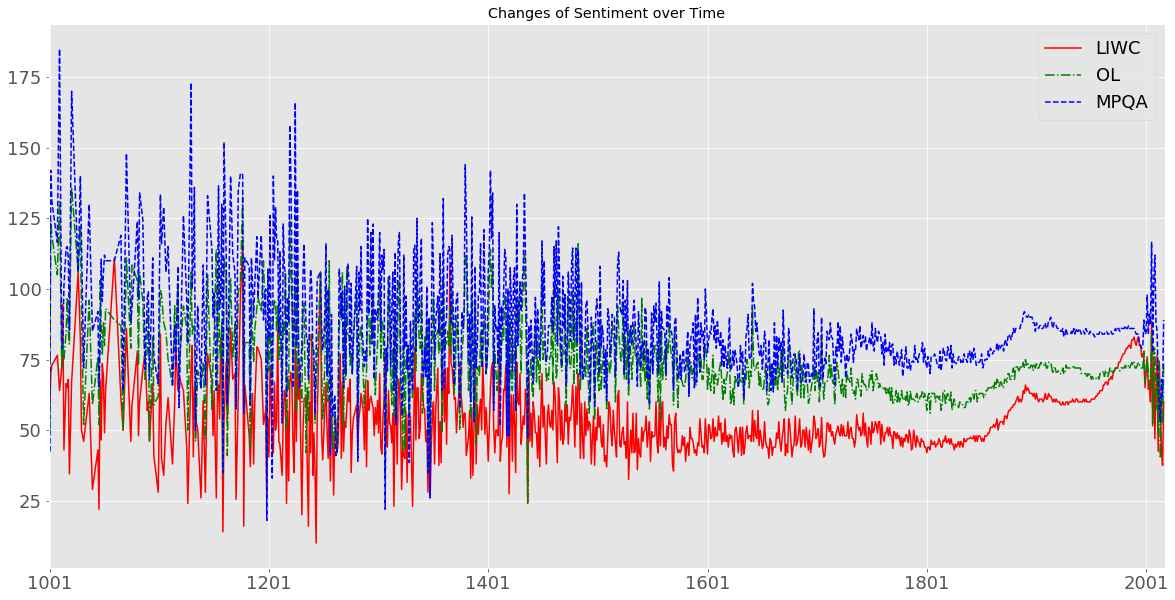

In [22]:
three_time_plot_for_year("People",[1000,1,1])

# Time plot for percentile

In [23]:
def get_percentile_df(lexicon_name,sentiment,category,time_unit,xaxis_value):
    # load score, date information before running this function
    # get scores dictionary, dates dictionary
    # dates
    # scores
    
    # preprocessing
    # merge date and score
    dateSenti_withBC = merge_date_score(lexicon_name,sentiment,category)
    # exclude date BC
    dateSenti = exclude_BC(dateSenti_withBC)
    # exclude high score (score == 1000)
    dateSenti = exclude_high_score(dateSenti)
    print ("dimension of dateSenti:")
    print (len(dateSenti['score']))
    #print (dateSenti)
    # add month or year (str) column
    #timeSenti = None
    df_display = {}
    result = []
    #subresult = []
    if time_unit == "year":
        df_display["year"] = {}
        # add year(str) column
        timeSenti = add_year_column(dateSenti)
        
        # for percentile 25th
        # get percentile 25th for each year
        time_percentile_25 = score_percentile_group_by_column(timeSenti,'year','score',0.25)
        # add year(datetime) column
        df_temp = add_datetimeYear_column(time_percentile_25)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["year"]["25"] = add_datetimeYear_column(time_percentile_25)
        # write into list
        subresult = []
        subresult.append(df_display["year"]["25"].datetime_year)
        subresult.append(df_display["year"]["25"].score)
        result.append(subresult)
        
        # for percentile 50th
        # get percentile 50th for each year
        time_percentile_50 = score_percentile_group_by_column(timeSenti,'year','score',0.5)
        print ("time_percentile_50:")
        print (time_percentile_50.head())
        # add year(datetime) column
        df_temp = add_datetimeYear_column(time_percentile_50)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["year"]["50"] = add_datetimeYear_column(time_percentile_50)
        print ("dimension of df_display[year][50] is:")
        print (len(df_display['year']['50']['score']))
        #print (df_display['year']['50']['score'])
        # write into list
        subresult = []
        subresult.append(df_display["year"]["50"].datetime_year)
        subresult.append(df_display["year"]["50"].score)
        result.append(subresult)
        
        # for percentile 75th
        # get percentile 75th for each year
        time_percentile_75 = score_percentile_group_by_column(timeSenti,'year','score',0.75)
        # add year(datetime) column
        df_temp = add_datetimeYear_column(time_percentile_75)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["year"]["75"] = add_datetimeYear_column(time_percentile_75)
        # write into list
        subresult = []
        subresult.append(df_display["year"]["75"].datetime_year)
        subresult.append(df_display["year"]["75"].score)
        result.append(subresult)
        
    elif time_unit == "month":
        df_display["month"] = {}
        timeSenti = add_month_column(dateSenti)
        
        # for percentile 25th
        # get percentile 25th for each month
        time_percentile_25 = score_percentile_group_by_column(timeSenti,'month','score',0.25)
        # add month(datetime) column
        df_temp = add_datetimeMonth_column(time_percentile_25)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["month"]["25"] = add_datetimeMonth_column(time_percentile_25)
        # write into list
        subresult = []
        subresult.append(df_display["month"]["25"].datetime_month)
        subresult.append(df_display["month"]["25"].score)
        result.append(subresult)
        
        # for percentile 50th
        # get percentile 50th for each month
        time_percentile_50 = score_percentile_group_by_column(timeSenti,'month','score',0.5)
        # add month(datetime) column
        df_temp = add_datetimeMonth_column(time_percentile_50)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["month"]["50"] = add_datetimeMonth_column(time_percentile_50)
        # write into list
        subresult = []
        subresult.append(df_display["month"]["50"].datetime_month)
        subresult.append(df_display["month"]["50"].score)
        result.append(subresult)
        
        # for percentile 75th
        # get percentile 75th for each month
        time_percentile_75 = score_percentile_group_by_column(timeSenti,'month','score',0.75)
        # add month(datetime) column
        df_temp = add_datetimeMonth_column(time_percentile_75)
        # extract items will be displayed in timeline (date within x-axis range)
        df_display["month"]["75"] = add_datetimeMonth_column(time_percentile_75)
        # write into list
        subresult = []
        subresult.append(df_display["month"]["75"].datetime_month)
        subresult.append(df_display["month"]["75"].score)
        result.append(subresult)

    # extract items will be displayed in timeline (date within x-axis range)
    #df_display = df_datetimeMonth_score[df_datetimeMonth_score['datetime_month'].isin(xaxis_value)]
    #print (df_display.head())
    
    return result

In [24]:
# time_unit: "year" or "month"
def time_plot_with_percentile(lexicon_name,sentiment,category,timeRange_start,time_unit):
    # load score, date information
    # get scores dictionary, dates dictionary
    # dates
    # scores
    # import functions
    
    # here we set start date and end date for timeline
    # timeRange_end is today
    # timeRange_start is a list [1000,1,1] consist of 3 int for year, month, date
    start_yy,start_mm,start_dd = timeRange_start

    start_date = date(start_yy,start_mm,start_dd)
    end_date = date.today()
    print ("start date of x-axis: %s"%(start_date))
    print ("end date x-axis: %s"%(end_date))
    
    # prepare data for x-axis
    # prepare data for x-axis
    #print (dir(rrule))
    freq = None
    if time_unit == "year":
        freq = rrule.YEARLY
    elif time_unit == "month":
        freq = rrule.MONTHLY
    xaxis_value = [day for day in rrule.rrule(freq,dtstart=start_date,until=end_date)]
    print ("value for x-axis looks like this: \n%s \nlen(x-axis): %d"%(xaxis_value[-1],len(xaxis_value)))
    
    # create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    #fig, ax = plt.subplots()
    ax.set_title('25th, 50th, 75th percentile of sentiment score over time')
    ax.set_xlim([start_date,end_date])
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    
    
    # get dataframe for month and score

    # result is a list with 3 elements, each element is a list with datetime_time and score
    # result=[[datetime,score for percentile 25],[datetime,score for 50],[datetime,score for 75]]
    result = get_percentile_df(lexicon_name,sentiment,category,time_unit,xaxis_value)
    print (len(result[0][0]))


    ax.plot(result[0][0],result[0][1],'-',color='blue',label="25th percentile")
    ax.plot(result[1][0],result[1][1],' ',color='red',label="50th percentile/median")
    ax.plot(result[2][0],result[2][1],'.',color='green',label="75th percentile")
    
    y_max = max(result[2][1])
    print (y_max)
    ax.set_ylim([0,150])

    

    #legend.get_frame().set_facecolor('#00FFCC')
    ax.legend(loc='upper right',fontsize=18)
    plt.show()


start date of x-axis: 1600-01-01
end date x-axis: 2017-11-03
value for x-axis looks like this: 
2017-01-01 00:00:00 
len(x-axis): 418
before exclude short articles
(22846, 3)
after exclude short articles
(22846, 3)
rows of dates[category], rows of scores[lexicon_name][sentiment]:
(23865, 2) (5416537, 2)
There are 34 dates before Christ,22812 entities left after excluding
dimension of dateSenti:
22794
time_percentile_50:
   year  score
0  0001   67.0
1  0002   17.0
2  0005   84.0
3  0006   74.5
4  0008   35.0
dimension of df_display[year][50] is:
937
937
274.5


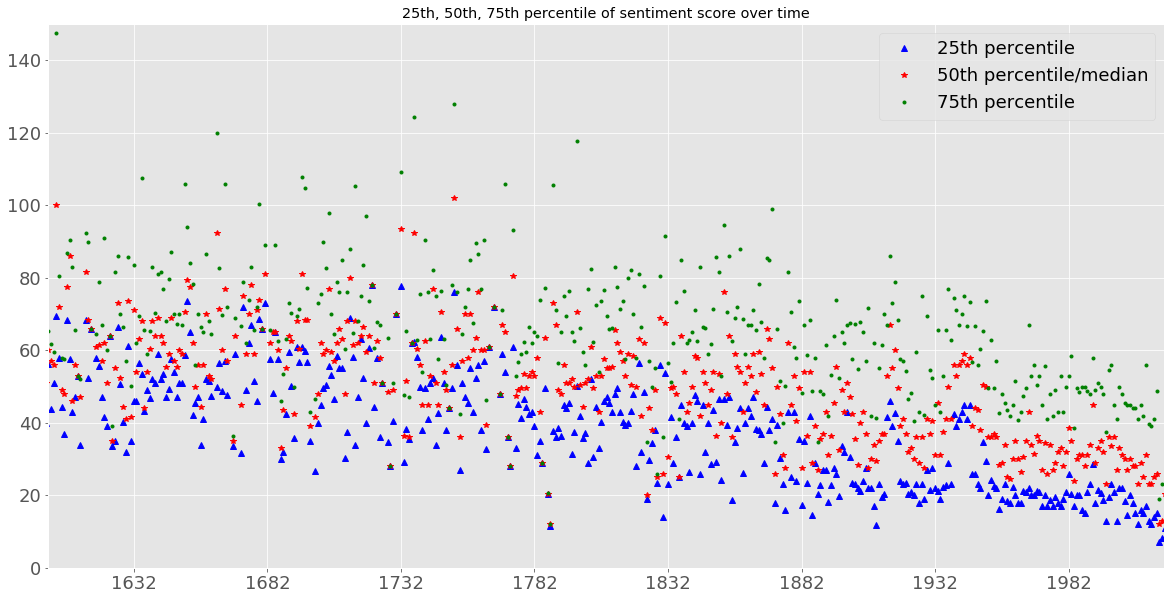

In [50]:
time_plot_with_percentile("LIWC","negative","Events",[1600,1,1],"year")

# The end

the left part is useless

In [104]:
def add_datetimeDate_column(df):
    # df.loc[] is more efficient than df[], and prevent SettingWithCopyWarning
    #dateSenti.loc[:,'datetimetype']=pd.Series(new_list,index=dateSenti.index)
    # more efficient: assign
    new_list = [datetime.strptime(one,'%Y-%m-%d').date() for one in df['date']]
    df = df.assign(datetimetype=pd.Series(new_list).values)
    return df
def add_datetimeMonth_column(df):
    # df.loc[] is more efficient than df[], and prevent SettingWithCopyWarning
    #dateSenti.loc[:,'datetimetype']=pd.Series(new_list,index=dateSenti.index)
    # more efficient: assign
    new_list = [datetime.strptime(one,'%Y-%m-%d').month() for one in df['date']]
    print (new_list[1])
    df = df.assign(month=pd.Series(new_list).values)
    return df
def add_int_score_column(df):
    new_list = [int(one) for one in df['score']]
    df = df.assign(score_int=pd.Series(new_list).values)
    return df
#print (dateSenti.head())
#dateSenti = add_datetime_column(dateSenti)
#dateSenti = add_int_score_column(dateSenti)
#print (dateSenti.head())
#monthSenti = add_datetimeMonth_column(dateSenti)
a = "0015-09-24"
b = datetime.strptime(a,'%Y-%m-%d')
print (dir(b))
print (b.month)
print (b.isocalendar())
print (b.isoformat())
print (b.isoweekday())
print (b.year)

['__add__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', 'astimezone', 'combine', 'ctime', 'date', 'day', 'dst', 'fromordinal', 'fromtimestamp', 'hour', 'isocalendar', 'isoformat', 'isoweekday', 'max', 'microsecond', 'min', 'minute', 'month', 'now', 'replace', 'resolution', 'second', 'strftime', 'strptime', 'time', 'timestamp', 'timetuple', 'timetz', 'today', 'toordinal', 'tzinfo', 'tzname', 'utcfromtimestamp', 'utcnow', 'utcoffset', 'utctimetuple', 'weekday', 'year']
9
(15, 39, 4)
0015-09-24T00:00:00
4
15


In [83]:
print (len(dateSenti))
dateSenti = dateSenti[dateSenti['score']!=1000]
print (len(dateSenti))

3878
3861


In [88]:
dir(dateSenti['datetimetype'][1])

['__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 'ctime',
 'day',
 'fromordinal',
 'fromtimestamp',
 'isocalendar',
 'isoformat',
 'isoweekday',
 'max',
 'min',
 'month',
 'replace',
 'resolution',
 'strftime',
 'timetuple',
 'today',
 'toordinal',
 'weekday',
 'year']

In [84]:
#dateSenti.groupby(dateSenti.datetimetype.dt
#print (type(dateSenti['datetimetype'][1]))
#dir(dateSenti['datetimetype'].dt)
df_date_score = dateSenti.groupby('datetimetype').agg({'score':np.median}).reset_index()
print (df_date_score.head())

  datetimetype  score
0   0009-11-17     60
1   0015-09-24     42
2   0019-01-30     25
3   0030-11-08     68
4   0053-09-18     57


In [85]:
#df_date_score = df_date_score.sort_values('datetimetype',ascending=True)
plt.plot(df_date_score['datetimetype'],df_date_score['score'])
#plt.xticks(rotation='vertical')

ValueError: ordinal must be >= 1

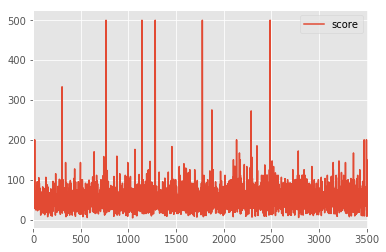

In [86]:
df_date_score.plot()

In [16]:
dir(dateSenti_withoutBC['date'].dt)

AttributeError: Can only use .dt accessor with datetimelike values

In [14]:
print (dir(dateSenti['date']))

['T', '_AXIS_ALIASES', '_AXIS_IALIASES', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_SLICEMAP', '__abs__', '__add__', '__and__', '__array__', '__array_prepare__', '__array_priority__', '__array_wrap__', '__bool__', '__bytes__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__int__', '__invert__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__long__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '

In [3]:

data_1 = pd.read_csv("title_long_lat_2_test.csv", names=['title','x1','x2'])
data_2 = pd.read_csv("title_long_lat_3_test.csv", names=['title','x3','x4'])

data_3 = data_1.merge(data_2)
data_3




,title,x1,x2,x3,x4
0,Algeria,3.216667,36.7,2.0,28.0
1,Andorra,1.516667,42.5,1.5,42.5
